# Evaluation

The `Source` class provides an interface and predefined methods for reading raw data from file.
If `source.use_nexus == True` the raw data will be saved and read preferentially from a generated `nexus` file, which results in a single data file with high compression and fast data access.

The `Source` class provides a `dict()` of all scans, called `scan_dict`.
The items in this dictionary are instances of the `Scan` class, which defines the common data structure.
However, the access to the scan data should NOT be done via the `scan_dict` directly, but instead for a deticated scan via `source.get_scan_data(scan_number)` or for a list of scans via `source.get_scan_list_data(scan_number_list)`.
By this all features of the `Source` class can be provided.

One key concept of the `pyEvalData` is the idea, that `Scan` instance must only provide the meta information of the scan but necessarily also its data.
By the default, the scan data will only be read on request and is then stored in the `Scan` object for later use.
It is possible, however to read all data to each scan by default by `source.read_all_data = Ture`.
On the other hand, if the data is allocating too much memory, it is possible to clear the data from the `Scan` object, directly after accessing it, via `source.read_and_forget = True`.
The flag `source.update_before_read` enables parsing the raw source file to search and add new scans before accessing any scan.
By default the last `Scan` in the `scan_dict` will always be re-created in case new data was added.
The flag `source.force_overwrite` will force a full parsing of the raw source file and a complete overwrite of the `nexus` file.

Any specific data source class must inherit from the base `Source` class and must only provide the two methods `parse_raw()` and `read_raw_ scan_data(scan)`, which parse the raw source to create the `scan_dict` and to read the actual scan data, respectivly.
With that a rather generic interface for nearly any kind of data source should be possible.

## Setup

Here we do the necessary import for this example

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

import pyEvalData as ped

## SPEC

The most common data source are SPEC files from the original [Certif SPEC](https://certif.com/content/spec) as well as from the open-source alternative [Sardana](https://sardana-controls.org).
The `Spec` source relies on the great parser provided by [xrayutilities](https://xrayutilities.sourceforge.io).

In [2]:
spec = ped.io.Spec(file_name='certif_xu.spec',
                   file_path='data/',
                   use_nexus=True,
                   force_overwrite=False,
                   update_before_read=False,
                   read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_nexus


As described above, the scan data and meta information should be accessed via `spec.get_scan_data(scan_number)`.  
Here, `data` is returned as `numpy.recarray` and `meta` is a `dict()`.

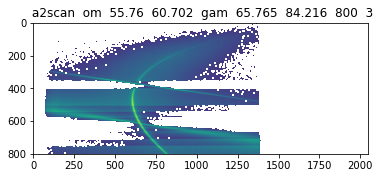

In [3]:
data, meta = spec.get_scan_data(33)

plt.figure()
plt.imshow(np.log10(data['MCA']))
plt.title(meta['cmd'])
plt.show()

One can also directly work with the `Scan` objects, which provides nearly the same functionality as above but misses to automatically `read_and_forget` the data.
Below, the example from above is reproduces with the `Scan`. Here one can also easily access the meta information as attributes of the `Scan` instance.

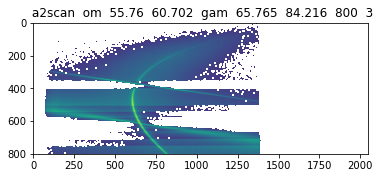

In [4]:
scan = spec.get_scan(33)

plt.figure()
plt.imshow(np.log10(scan.MCA))
plt.title(scan.cmd)
plt.show()

It is also possible to access the scan directly as attribute of the source which is fully aquivalent to the last example

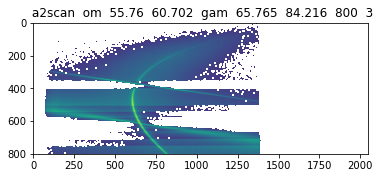

In [5]:
plt.figure()
plt.imshow(np.log10(spec.scan33.MCA))
plt.title(spec.scan33.cmd)
plt.show()

## Sardana NeXus

The [NeXus fiel format](https://www.nexusformat.org) is a common standard in science for storing and exchanging data.
It is based on `hdf5` files with a hierarchical desgin. As an example we read the NeXus files as created by Sardana.
As we can directly access the data from the NeXus files, there is no need to enable additional NeXus export so one can set `source.use_nexus = False`.

In [6]:
sarnxs = ped.io.SardanaNeXus(file_name='sardana_nexus.h5',
                             file_path='data/',
                             use_nexus=False,
                             force_overwrite=False,
                             update_before_read=False,
                             read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw


pyEvalData.io.source - INFO: read_raw_scan_data for scan #435


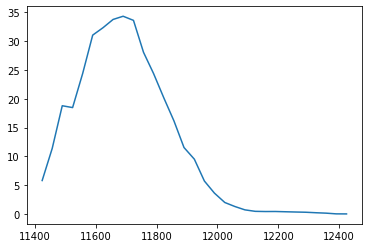

In [7]:
plt.figure()
plt.plot(sarnxs.scan435.mhor, sarnxs.scan435.pmPump)
plt.show()

## PAL FEL

In [8]:
pal = ped.io.PalH5(name='2020_12_Schick',
                   file_name='{0:07d}',
                   file_path='./data/pal_fel',
                   use_nexus=False,
                   force_overwrite=False,
                   update_before_read=True,
                   read_and_forget=True,
                   nexus_file_path='./',
                   nexus_file_name='2020_12_Schick')

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_raw


In [9]:
s = ped.Evaluation(pal)

In [10]:
cdef = {
             'apd1'        : 'digi1_2',
             'apd2'        : 'digi1_1', 
             'apd3'        : 'digi1_3',
             'mcp'         : 'digi1_0', 
             'frontPD'     : 'digi2_0',
             'rearPD'      : 'digi2_1',
             'chn'         : 'digi2_2',
             'laserPD'     : 'digi2_3',
            }
statistic_type = 'gaussian'
propagate_errors = False
math_keys = ['mean', 'sum', 'diff', 'max', 'min', 'round', 'abs',
            'sin', 'cos', 'tan', 'arcsin', 'arccos', 'arctan',
            'pi', 'exp', 'log', 'log10', 'sqrt', 'mod', 'int32', 'std']

In [11]:
s.cdef = cdef
s.math_keys = math_keys
s.statistic_type = statistic_type
s.propagate_errors = propagate_errors

pyEvalData.io.source - INFO: read_raw_scan_data for scan #9


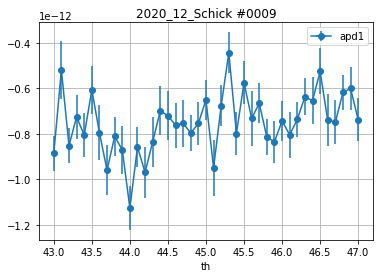

In [12]:
plt.figure()
s.xcol = 'th'
s.clist = ['apd1']

s.plot_scans([9], xgrid=np.r_[-1000:1000:0.0001], yerr='err')

plt.show()

## Composite Sources

On specific idea of the `Source` class is to provide also composite models of pre-defined `Source` classes.
An example is the `Spec` source for reading SPEC data files and a `Source` class to read camera images from a folder structure, that have been acquired simultaneously with the SPEC file.
This would require to specify the two independent `Souce` objects and then add them to a single `CompositeSource`:
```python
spec = ed.io.Spec(file_name, file_path)
ccd = ed.io.Pilatus(image_pattern, image_base_path)

comp_source = spec + ccd
```